In [60]:
import os
import random
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F


from model.networks import Generator
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, normalize, get_model_list

import numpy as np
import matplotlib.pyplot as plt

In [61]:
IMG_PATH = "/var/tmp/namespace/hendrycks/imagenet/val/n03874599/ILSVRC2012_val_00004826.JPEG"
CHECKPOINT_PATH = "hole_benchmark/gen_00430000.pt"

In [62]:
def get_image(path, img_shape=(256, 256)):
    img = default_loader(path)
    img = transforms.Resize(img_shape)(img)
    img = transforms.CenterCrop(img_shape)(img)
    img = transforms.ToTensor()(img)
    img = normalize(img)
    img = img.unsqueeze(dim=0)
    return img

ground_truth_image = get_image(IMG_PATH) # (1, 3, 256, 256)

In [63]:
def random_mask(mask_shape=(50, 50), img_shape=(256, 256), num=1):
    """Generate a random tlhw with configuration.

    Args:
        config: Config should have configuration including img

    Returns:
        tuple: (top, left, height, width)

    """
    img_height, img_width = img_shape
    h, w = mask_shape
    maxt = img_height - h
    maxl = img_width - w
    bbox_list = []
    for i in range(num):
        t = np.random.randint(0, maxt)
        l = np.random.randint(0, maxl)
        bbox_list.append((t, l, h, w))

        
    
    return torch.tensor(bbox_list, dtype=torch.int64)


def apply_masks(bboxes, image):
    """
    image: (C, H, W)
    """
    # 0 for masked out, 1 for not masked
    mask_composite = torch.ones((1, image.shape[1], image.shape[2]))

    for t, l, h, w in bboxes:
        mask = torch.zeros_like(image)
        mask[:, t:t+h, l:l+w] = 1
        image = image * (1.0 - mask)
        mask_composite = mask_composite * (1.0 - mask[0])
    
    return image, mask_composite

tensor(0.)
tensor(1.)


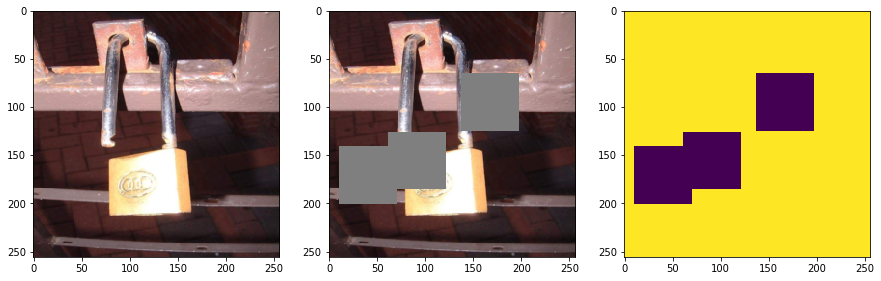

In [64]:
def show_image(image, plt=plt):
    image = (image.detach().cpu() + 1) / 2
    
    if image.shape[0] == 1:
        plt.imshow(image.squeeze(0).numpy())
    else:
        plt.imshow(image.numpy().transpose(1,2,0))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
show_image(ground_truth_image[0], ax[0])

# Make masked version
masked_image, mask = apply_masks(random_mask(num=3, mask_shape=(60, 60)), ground_truth_image[0])
show_image(masked_image, ax[1])
show_image(mask, ax[2])
print(torch.min(mask))
print(torch.max(mask))

In [68]:
blocks_coarse = [
    "coarse_generator.conv1",
    "coarse_generator.conv2_downsample",
    "coarse_generator.conv3",
    "coarse_generator.conv4_downsample",
    "coarse_generator.conv5",
    "coarse_generator.conv6",
    "coarse_generator.conv7_atrous",
    "coarse_generator.conv8_atrous",
    "coarse_generator.conv9_atrous",
    "coarse_generator.conv10_atrous",
    "coarse_generator.conv11",
    "coarse_generator.conv12",
    "coarse_generator.conv13",
    "coarse_generator.conv14",
    "coarse_generator.conv15",
    "coarse_generator.conv16",
    "coarse_generator.conv17",
]

blocks_fine = [
    "fine_generator.conv1",
    "fine_generator.conv2_downsample",
    "fine_generator.conv3",
    "fine_generator.conv4_downsample",
    "fine_generator.conv5",
    "fine_generator.conv6",
    "fine_generator.conv7_atrous",
    "fine_generator.conv8_atrous",
    "fine_generator.conv9_atrous",
    "fine_generator.conv10_atrous",
    "fine_generator.pmconv1",
    "fine_generator.pmconv2_downsample",
    "fine_generator.pmconv3",
    "fine_generator.pmconv4_downsample",
    "fine_generator.pmconv5",
    "fine_generator.pmconv6",
    "fine_generator.pmconv9",
    "fine_generator.pmconv10",
    "fine_generator.allconv11",
    "fine_generator.allconv12",
    "fine_generator.allconv13",
    "fine_generator.allconv14",
    "fine_generator.allconv15",
    "fine_generator.allconv16",
    "fine_generator.allconv17",
]

blocks_all = blocks_coarse + blocks_fine

def get_weights(path=CHECKPOINT_PATH):
    weights = torch.load(path)
    
    random_sample_list = np.random.randint(0,4, size=1)
    # random_sample_list = [1]
    print("Random Sample List = ", random_sample_list)
    for option in random_sample_list:
        if option == 0:
            rand_conv = random.choice(blocks_all) + ".conv"
            weights[rand_conv + ".weight"] = torch.flip(weights[rand_conv + ".weight"], (0,))
            weights[rand_conv + ".bias"] = torch.flip(weights[rand_conv + ".bias"], (0,))
        elif option == 1:
            rand_conv = random.choice(blocks_all) + ".conv"
            weights[rand_conv + ".weight"] = -weights[rand_conv + ".weight"]
            weights[rand_conv + ".bias"] = -weights[rand_conv + ".bias"]
        elif option == 2:
            rand_conv = random.choice(blocks_all) + ".conv"
            weights[rand_conv + ".weight"] = F.gelu(weights[rand_conv + ".weight"])
            weights[rand_conv + ".bias"] = F.gelu(weights[rand_conv + ".bias"])
        elif option == 3:
            rand_conv = random.choice(blocks_all) + ".conv"
            weights[rand_conv + ".weight"] = F.dropout(weights[rand_conv + ".weight"], 0.5)
            weights[rand_conv + ".bias"] = F.dropout(weights[rand_conv + ".bias"], 0.5)
        else:
            raise NotImplementedError()
    
    return weights 

In [69]:
netG = Generator(config={"input_dim": 3, "ngf": 32}, use_cuda=True).cuda()
netG.load_state_dict(get_weights())

Random Sample List =  [0]


<All keys matched successfully>

Random Sample List =  [0]
Random Sample List =  [2]
Random Sample List =  [1]
Random Sample List =  [0]


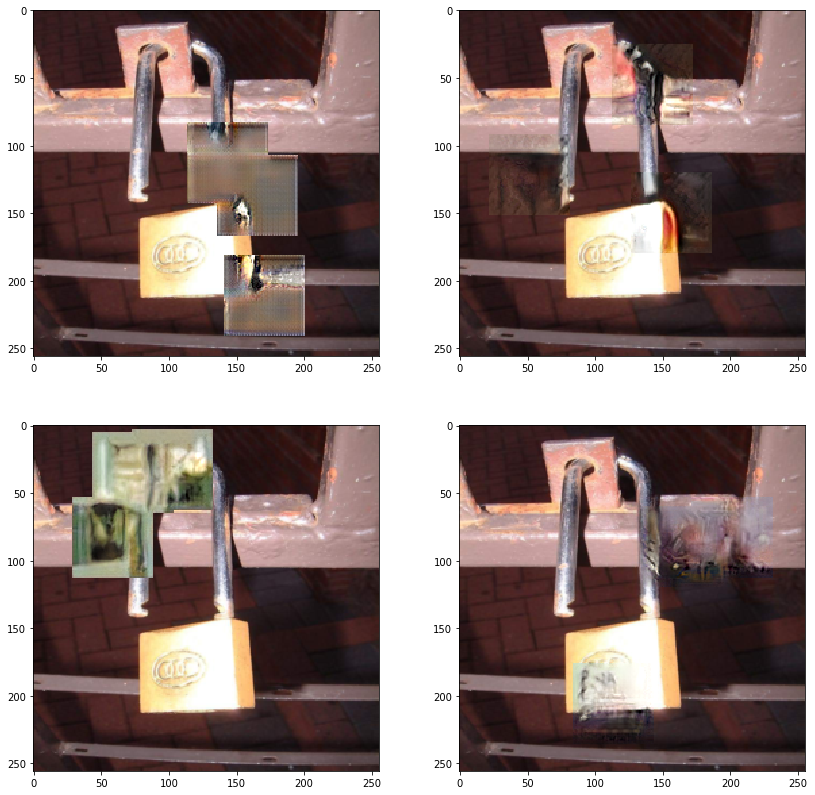

In [70]:
# Run inference
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
figure_indices = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]
for x, y in figure_indices:
    masked_image, mask = apply_masks(random_mask(num=3, mask_shape=(60, 60)), ground_truth_image[0])
    input_batch = masked_image.unsqueeze(0).cuda()
    input_mask_batch = mask.unsqueeze(0).cuda()
    input_mask_batch = 1 - input_mask_batch

    netG.load_state_dict(get_weights())
    x1, x2, offset_flow = netG(input_batch, input_mask_batch)
    inpainted_result = x2 * (input_mask_batch.cuda()) + input_batch * (1.0 - input_mask_batch.cuda())

    show_image(inpainted_result[0], plt=ax[x][y])